In [1]:
import scanpy as sc
import graph_tool.all as gt
import schist
import pandas as pd
import anndata
import pickle
import mygene
import seaborn as sns
import scipy.stats
%pylab
%matplotlib inline

/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/all.py:40: RuntimeWarning: Error im

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


# Equilibrate true

In [2]:
markers = pd.read_excel('../benchmarking_data/41587_2020_469_MOESM4_ESM.xlsx', skiprows=2)
cols = markers.columns
cols = [x.replace(' ', '_') for x in cols]
cols = [x.replace('+', '') for x in cols]
cols = [x.replace('-', '_') for x in cols]
cols = [x.replace('_cell', '') for x in cols]
markers.columns = cols

In [3]:
tdata = pd.read_table("../benchmarking_data/GSE133543_QUARTZseq_human_exp_mat.tsv.gz", compression='gzip')
adata = anndata.AnnData(tdata.T)

In [4]:
metadata = pd.read_table("../benchmarking_data/GSE133543_QUARTZseq_human_metada.tsv.gz", compression='gzip')

In [5]:
hca_annot = pd.read_table("../benchmarking_data/HCA_annotations.txt")
cells = [x for x in hca_annot.query('batch == "Quartz-Seq2"').index if x in adata.obs_names]

adata = adata[cells]

adata.obs['nnet2'] = hca_annot.loc[cells, 'nnet2']
sc.pp.filter_genes(adata, min_cells=5)



Trying to set attribute `.obs` of view, copying.


In [6]:
mg = mygene.MyGeneInfo()

In [7]:

ensgenes = [x.split('.')[0] for x in adata.var_names]
conversion = mg.querymany(ensgenes, scopes='ensemblgene', fields='symbol', species='human', as_dataframe=True)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-26000...done.
querying 26001-27000...done.
querying 27001-27990...done.
Finished.


/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/biothings_client/base.py:143: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df = json_normalize(obj)


2 input query terms found dup hits:
	[('ENSG00000002586', 2), ('ENSG00000229425', 2)]
139 input query terms found no hit:
	['ENSG00000116883', 'ENSG00000154537', 'ENSG00000163009', 'ENSG00000167945', 'ENSG00000168078', 'ENS
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [8]:
nv = []
for e in adata.var_names:
    k = e.split('.')[0]
    symbol = conversion.loc[k, 'symbol']
    if type(symbol) == str:
        nv.append(symbol)
    else:
        nv.append(e)
adata.var_names = nv
adata.var_names_make_unique()        

In [9]:
mito_genes = adata.var_names.str.startswith('MT-') 
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1) 
adata.obs['n_counts'] = adata.X.sum(axis=1)
adata = adata[adata.obs['percent_mito'] < 0.25, :]
sc.pp.filter_cells(adata, min_genes=0)
count_thr = scipy.stats.scoreatpercentile(adata.obs['n_genes'], 95)
adata = adata[adata.obs.n_genes < count_thr, :]

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10)
sc.settings.verbosity=2

Trying to set attribute `.obs` of view, copying.
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:297: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/anndata/_core/anndata.py:1171: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'nnet2' as categorical


In [10]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
sc.tl.umap(adata)

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:04)
computing UMAP
    finished (0:00:05)


In [11]:
sc.tl.diffmap(adata, n_comps=20)
sc.pp.neighbors(adata, n_pcs=20, n_neighbors=30,use_rep='X_diffmap')

computing Diffusion Maps using n_comps=20(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99905866 0.996642   0.992895   0.98864645 0.9872168
     0.96640307 0.9622898  0.9603701  0.95458657 0.95234364 0.9295605
     0.9187538  0.90552855 0.8938475  0.8901244  0.8820491  0.8768519
     0.87372315 0.8513623 ]
    finished (0:00:00)
computing neighbors
    finished (0:00:00)


In [12]:
sc.tl.leiden(adata)

running Leiden clustering
    finished (0:00:00)


In [20]:
adata.write('state_adata/adata_quartzseq_denoised.h5ad')

NotImplementedError: Failed to write value for uns/nsbm/state, since a writer for type <class 'graph_tool.inference.nested_blockmodel.NestedBlockState'> has not been implemented yet.

Above error raised while writing key 'uns/nsbm/state' of <class 'h5py._hl.files.File'> from /.

In [21]:
adata=sc.read('state_adata/adata_quartzseq_denoised.h5ad')

In [22]:
schist.inference.nested_model(adata, equilibrate=False,use_weights=True, deg_corr=True, steps_anneal=3,n_init=3)

minimizing the nested Stochastic Block Model
    done (0:10:59)
    calculating cell affinity to groups
    finished (0:11:06)


In [23]:
schist.io.write(adata, prefix='state_adata/Quartzseq_minimize_weighted_denoised')

In [24]:
adata=scnsbm.io.read('state_adata/Quartzseq_minimize_weighted_denoised')

NameError: name 'scnsbm' is not defined

<BarContainer object of 10 artists>

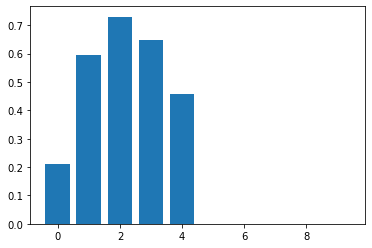

In [17]:
modularity=[x for x in adata.uns['nsbm']['stats']['modularity']]
levels=[x for x in range(len(modularity))]
bar(levels,modularity)

<ipython-input-28-a8ff4d383f77>:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  flat=pd.Series()
/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3256: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


1
2
4
5
6
7
8
9
10
11
12
13
14
15
16
17
20


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


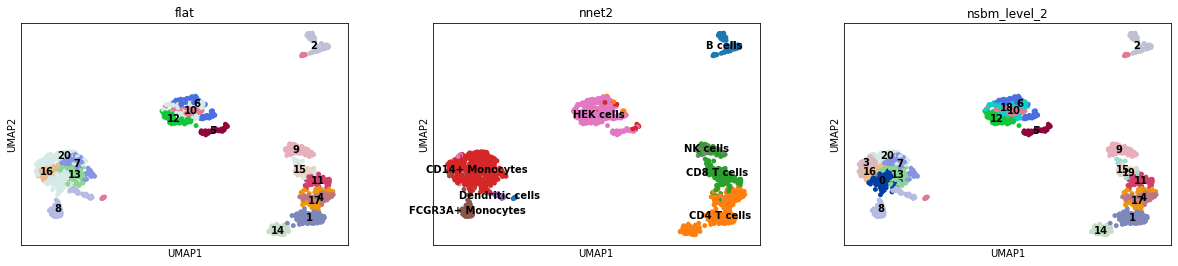

[0.05747126436781609, 0.0, 0.0, 0.10204081632653061, 0.025, 0.0, 0.037037037037037035, 0.014285714285714285, 0.0, 0.0, 0.01818181818181818, 0.021739130434782608, 0.03076923076923077, 0.029850746268656716, 0.0, 0.0, 0.029411764705882353, 0.0, 0.07272727272727272, 0.06896551724137931, 0.0196078431372549]


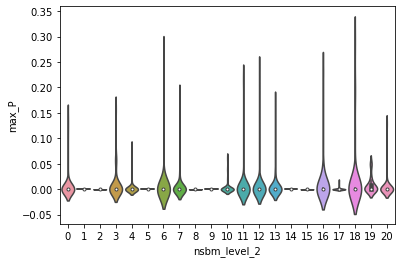

In [28]:
level=str(3)
marginals = adata.uns['nsbm']['cell_affinity'][level] 
adata.obs['max_P'] = -np.log10(np.max(marginals, axis=1))
#adata.obs['max_P'] = np.max(marginals,axis=1)
group_sig=[]
group_names = adata.obs[f'nsbm_level_{level}'].cat.categories
for group in group_names:
    adata0=adata[adata.obs[f'nsbm_level_{level}']==group]
    c=0
    for i in adata0.obs['max_P']:
        if i>0.05:
#        if i>0.95:
            c=c+1
    c=c/(len(adata0.obs['max_P']))
    group_sig.append(c)
cdata=adata
flat=pd.Series()
for i in range(len(group_sig)):
    if group_sig[i]<0.05:
#    if group_sig[i]>0.95:
        a=pd.Series(cdata.obs[f'nsbm_level_{level}'][cdata.obs[f'nsbm_level_{level}']==str(i)], index=cdata.obs[f'nsbm_level_{level}'].index[cdata.obs[f'nsbm_level_{level}']==str(i)])
        flat=pd.Series.append(flat,a, ignore_index=False, verify_integrity=True)
        print(i)
cdata.obs['flat']=flat
sc.pl.umap(cdata, color=['flat','nnet2',f'nsbm_level_{level}'],legend_loc='on data')
print(group_sig)

sns.violinplot(x=f'nsbm_level_{level}', y='max_P', data = adata.obs, scale='width')

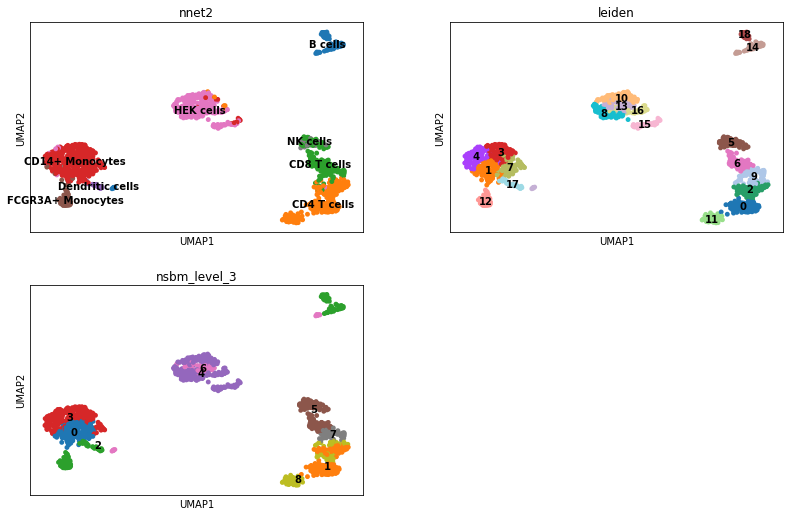

In [27]:
sc.pl.umap(adata, color=['nnet2', 'leiden', 'nsbm_level_3'], ncols=2, legend_loc='on data')

In [25]:
#minimize weighted denoised
sum(adata.uns['nsbm']['stats']['level_entropy'])

22476.690265791694

In [19]:
#minimize flat denoised
sum(adata.uns['nsbm']['stats']['level_entropy'])

42153.80971161385

In [22]:
#minimize weighted
sum(adata.uns['nsbm']['stats']['level_entropy'])

55139.87991147389

In [15]:
#minimize flat
sum(adata.uns['nsbm']['stats']['level_entropy'])

56440.93304978711

# PAGA

paga leiden
running PAGA
    finished (0:00:00)


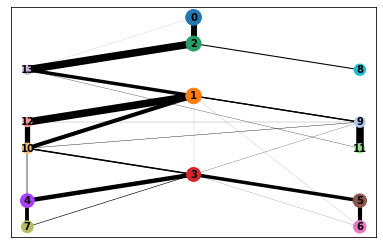

paga nsbm
running PAGA
    finished (0:00:00)


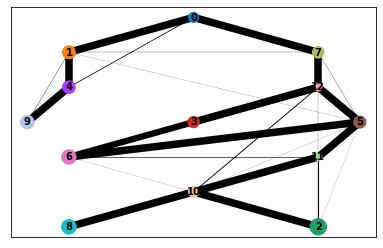

paga nnet2
running PAGA
    finished (0:00:00)


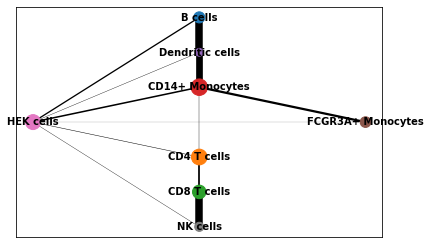

In [21]:
print('paga leiden')
sc.tl.paga(adata,groups='leiden')
sc.pl.paga(adata, color=['leiden'],layout='eq_tree')
print('paga nsbm')
sc.tl.paga(adata,groups='nsbm_level_2')
sc.pl.paga(adata, color=['nsbm_level_2'],layout='eq_tree')
print('paga nnet2')
sc.tl.paga(adata,groups='nnet2')
sc.pl.paga(adata, color=['nnet2'],layout='eq_tree')

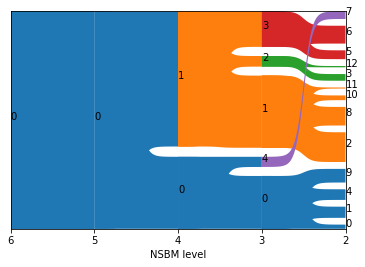

In [22]:
scnsbm.pl.alluvial(adata,level_end=6, level_start=2)

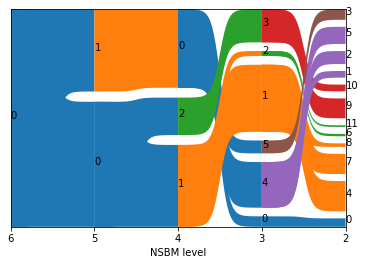

In [22]:
scnsbm.pl.alluvial(adata,level_end=6, level_start=2)

### MARGINALS

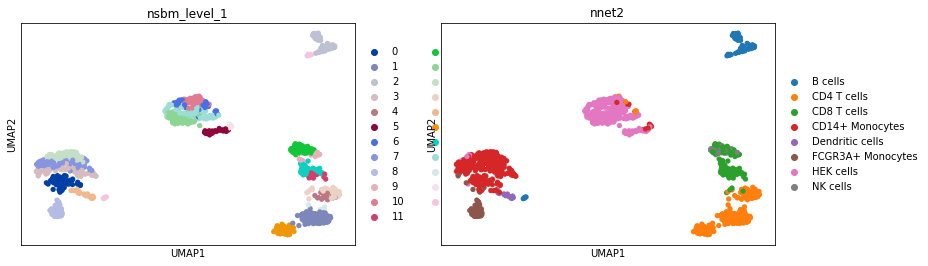

In [26]:
E=adata.uns['nsbm']['cell_affinity']['2']
adata.obs['max_u'] = 1 - np.max(E, axis=1) 
sc.pl.umap(adata[adata.obs.max_u < 1e-10], color=['nsbm_level_1','nnet2'])

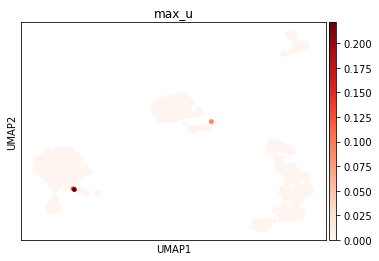

In [31]:
sc.pl.umap(adata, color ='max_u',color_map='Reds')